In [1]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


In [4]:
lotto = pd.read_csv('melate2.csv', index_col = 'FECHA')

print(lotto)

            R1  R2  R3  R4  R5  R6  R7
FECHA                                 
1984-08-19   1   4   7  11  19  30  36
1984-08-26   5   6  24  30  34  38  32
1984-09-02  16  18  19  21  29  32  27
1984-09-09   8  12  15  18  20  34  37
1984-09-16   4  10  13  18  33  39  11
...         ..  ..  ..  ..  ..  ..  ..
2022-02-25   5  10  14  24  49  54  32
2022-02-27  13  18  22  33  43  53  25
2022-03-02   8  12  13  28  34  48  43
2022-03-04  15  17  26  31  37  42  29
2022-03-06   5   6  12  21  53  55  15

[3557 rows x 7 columns]


Train Test Split¶
Use the last 50 draws as the test dataset Use a sliding window of 10 to split the input data

In [5]:
data = lotto.values - 1
train = data[:-50]
test = data[-50:]

w = 30
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [6]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3557, 7)
(3477, 30, 7)
(3477, 7)
(50, 30, 7)
(50, 7)


## Seq2Seq Model to Predict Future Draws

In [7]:
embed_dim = (59 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 7
feature_count = embed_dim * 7
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [8]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 59 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(59, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(59, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(59, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(59, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(59, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(59, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(59, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(59, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 30)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 30)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 30)           0           input_1[0][0]                    
______________________________________________________________________________________________

In [10]:
import pydot
 

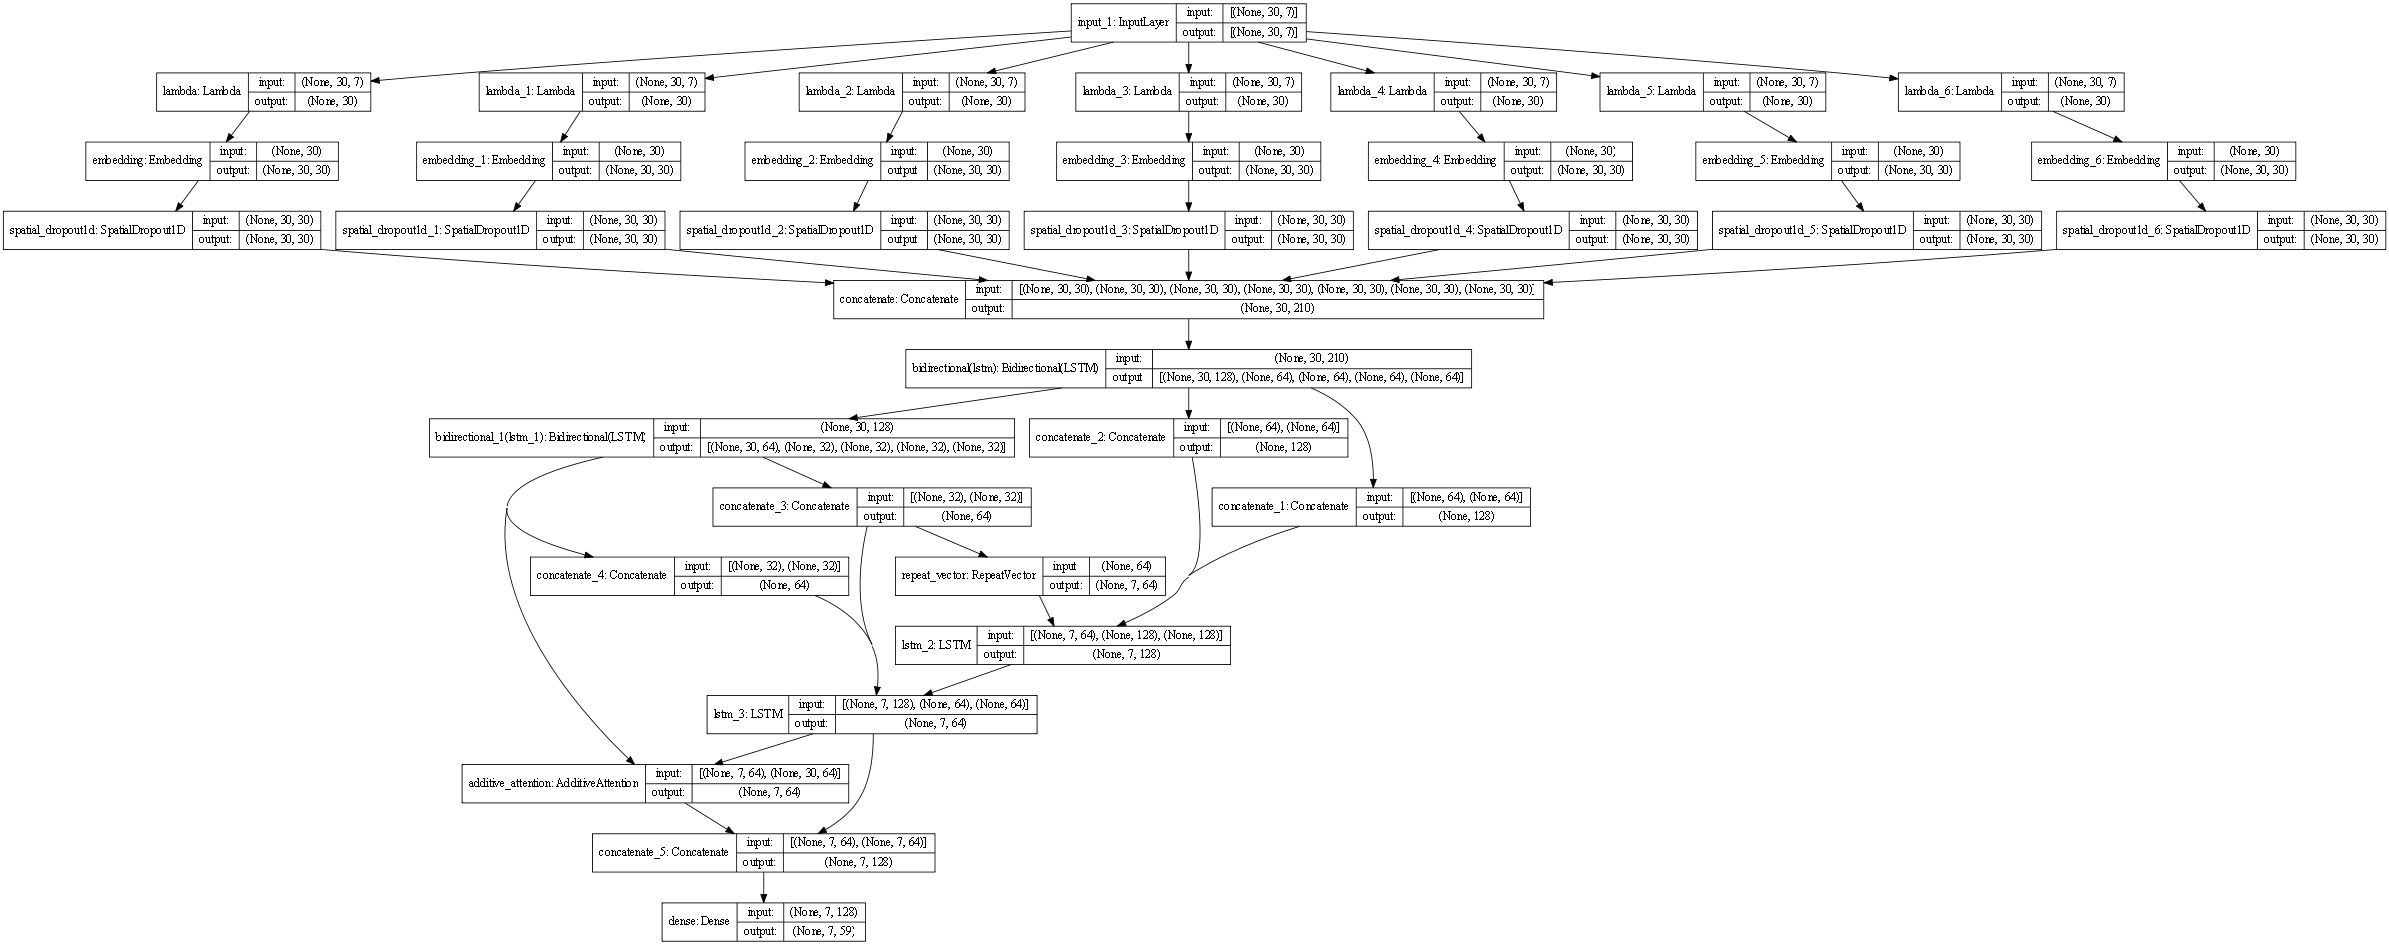

In [11]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [12]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [13]:
EPOCHS = 250
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/250
109/109 - 26s - loss: 4.0647 - sparse_top_k: 0.1093 - val_loss: 4.0661 - val_sparse_top_k: 0.0886
Epoch 2/250
109/109 - 5s - loss: 3.8401 - sparse_top_k: 0.1802 - val_loss: 3.9129 - val_sparse_top_k: 0.1686
Epoch 3/250
109/109 - 6s - loss: 3.6676 - sparse_top_k: 0.2292 - val_loss: 3.8140 - val_sparse_top_k: 0.1600
Epoch 4/250
109/109 - 5s - loss: 3.6030 - sparse_top_k: 0.2342 - val_loss: 3.7917 - val_sparse_top_k: 0.1771
Epoch 5/250
109/109 - 5s - loss: 3.5615 - sparse_top_k: 0.2481 - val_loss: 3.7451 - val_sparse_top_k: 0.1743
Epoch 6/250
109/109 - 5s - loss: 3.5300 - sparse_top_k: 0.2599 - val_loss: 3.7188 - val_sparse_top_k: 0.1914
Epoch 7/250
109/109 - 5s - loss: 3.5067 - sparse_top_k: 0.2668 - val_loss: 3.7039 - val_sparse_top_k: 0.1971
Epoch 8/250
109/109 - 5s - loss: 3.4870 - sparse_top_k: 0.2618 - val_loss: 3.6936 - val_sparse_top_k: 0.2114
Epoch 9/250
109/109 - 5s - loss: 3.4682 - sparse_top_k: 0.2689 - val_loss: 3.6956 - val_sparse_top_k: 0.2057
Epoch 10/250
109/1

Epoch 76/250
109/109 - 5s - loss: 3.3176 - sparse_top_k: 0.3089 - val_loss: 3.6108 - val_sparse_top_k: 0.2486
Epoch 77/250
109/109 - 5s - loss: 3.3158 - sparse_top_k: 0.3084 - val_loss: 3.6105 - val_sparse_top_k: 0.2457
Epoch 78/250
109/109 - 5s - loss: 3.3149 - sparse_top_k: 0.3107 - val_loss: 3.6503 - val_sparse_top_k: 0.2114
Epoch 79/250
109/109 - 5s - loss: 3.3150 - sparse_top_k: 0.3099 - val_loss: 3.6147 - val_sparse_top_k: 0.2486
Epoch 80/250
109/109 - 5s - loss: 3.3144 - sparse_top_k: 0.3117 - val_loss: 3.6150 - val_sparse_top_k: 0.2457
Epoch 81/250
109/109 - 5s - loss: 3.3143 - sparse_top_k: 0.3124 - val_loss: 3.6398 - val_sparse_top_k: 0.2257
Epoch 82/250
109/109 - 5s - loss: 3.3136 - sparse_top_k: 0.3133 - val_loss: 3.6242 - val_sparse_top_k: 0.2343
Epoch 83/250
109/109 - 5s - loss: 3.3151 - sparse_top_k: 0.3110 - val_loss: 3.6284 - val_sparse_top_k: 0.2314
Epoch 84/250
109/109 - 5s - loss: 3.3129 - sparse_top_k: 0.3138 - val_loss: 3.6039 - val_sparse_top_k: 0.2514
Epoch 85/2

109/109 - 5s - loss: 3.2900 - sparse_top_k: 0.3235 - val_loss: 3.6821 - val_sparse_top_k: 0.2200
Epoch 151/250
109/109 - 5s - loss: 3.2941 - sparse_top_k: 0.3185 - val_loss: 3.6432 - val_sparse_top_k: 0.2343
Epoch 152/250
109/109 - 5s - loss: 3.2930 - sparse_top_k: 0.3173 - val_loss: 3.6744 - val_sparse_top_k: 0.2200
Epoch 153/250
109/109 - 5s - loss: 3.2927 - sparse_top_k: 0.3185 - val_loss: 3.6325 - val_sparse_top_k: 0.2286
Epoch 154/250
109/109 - 5s - loss: 3.2948 - sparse_top_k: 0.3178 - val_loss: 3.6084 - val_sparse_top_k: 0.2371
Epoch 155/250
109/109 - 5s - loss: 3.2927 - sparse_top_k: 0.3229 - val_loss: 3.6304 - val_sparse_top_k: 0.2343
Epoch 156/250
109/109 - 5s - loss: 3.2940 - sparse_top_k: 0.3178 - val_loss: 3.6113 - val_sparse_top_k: 0.2143
Epoch 157/250
109/109 - 5s - loss: 3.2881 - sparse_top_k: 0.3227 - val_loss: 3.6206 - val_sparse_top_k: 0.2314
Epoch 158/250
109/109 - 5s - loss: 3.2930 - sparse_top_k: 0.3174 - val_loss: 3.6275 - val_sparse_top_k: 0.2343
Epoch 159/250
1

Epoch 224/250
109/109 - 5s - loss: 3.2845 - sparse_top_k: 0.3246 - val_loss: 3.6449 - val_sparse_top_k: 0.2286
Epoch 225/250
109/109 - 5s - loss: 3.2810 - sparse_top_k: 0.3268 - val_loss: 3.6425 - val_sparse_top_k: 0.2314
Epoch 226/250
109/109 - 5s - loss: 3.2829 - sparse_top_k: 0.3220 - val_loss: 3.6544 - val_sparse_top_k: 0.2343
Epoch 227/250
109/109 - 5s - loss: 3.2811 - sparse_top_k: 0.3258 - val_loss: 3.6520 - val_sparse_top_k: 0.2371
Epoch 228/250
109/109 - 5s - loss: 3.2815 - sparse_top_k: 0.3246 - val_loss: 3.6430 - val_sparse_top_k: 0.2286
Epoch 229/250
109/109 - 5s - loss: 3.2852 - sparse_top_k: 0.3230 - val_loss: 3.6508 - val_sparse_top_k: 0.2371
Epoch 230/250
109/109 - 5s - loss: 3.2851 - sparse_top_k: 0.3204 - val_loss: 3.6488 - val_sparse_top_k: 0.2314
Epoch 231/250
109/109 - 5s - loss: 3.2832 - sparse_top_k: 0.3240 - val_loss: 3.6529 - val_sparse_top_k: 0.2371
Epoch 232/250
109/109 - 5s - loss: 3.2860 - sparse_top_k: 0.3237 - val_loss: 3.6543 - val_sparse_top_k: 0.2314
E

0.2628571391105652


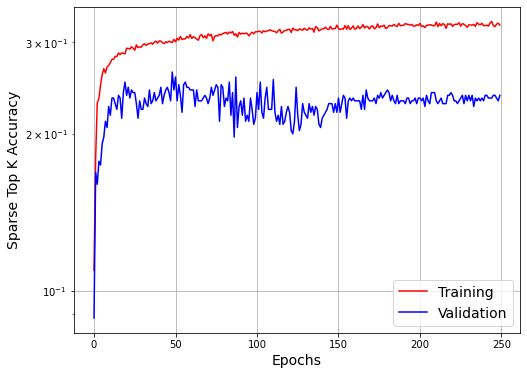

In [14]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [15]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

In [16]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [ 1  6 10 14 30 53 54]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [11 13 18 25 27 56 28]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [24 33 35 38 49 52  2]
----------------------------------------
Prediction:	 [ 1  8 24 32 41 56 26]
GoundTruth:	 [ 4  5 14 18 54 55 15]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [11 12 21 30 39 41 48]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [ 3 10 14 30 45 56  9]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [18 19 27 47 53 56 51]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [ 5 10 17 42 47 54 12]
----------------------------------------
Prediction:	 [ 1 13 24 32 41 56 26]
GoundTruth:	 [12 20 25 35 41 43  6]
------------------------

Predict the Future Draw on 2020/Aug/26

In [17]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, 7)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[14 15 32 50 53 55 43]
  [ 1  9 17 18 35 47 13]
  [ 3  7 13 32 40 41 22]
  [ 9 11 22 36 47 49 38]
  [ 2  9 11 17 27 42 25]
  [ 1  5 14 23 24 54 56]
  [13 22 28 33 34 50  7]
  [ 6 21 23 26 35 53 44]
  [12 17 18 37 44 50  8]
  [22 27 42 48 53 55 28]
  [ 1  3  8 17 36 41 44]
  [ 3  8 19 25 34 51 10]
  [ 3 18 19 45 49 50 54]
  [21 27 40 44 45 53 37]
  [15 16 40 41 51 52 25]
  [ 4  5 34 38 46 55 29]
  [10 14 34 37 42 54  1]
  [ 5 20 35 48 53 56 23]
  [29 36 38 39 42 49 48]
  [ 3  8 10 11 14 56 18]
  [11 28 41 44 47 55 52]
  [10 11 14 23 24 38 44]
  [ 6  7  8 25 26 40 55]
  [29 37 40 44 53 54 42]
  [20 46 50 53 54 55  6]
  [ 5 10 14 24 49 54 32]
  [13 18 22 33 43 53 25]
  [ 8 12 13 28 34 48 43]
  [15 17 26 31 37 42 29]
  [ 5  6 12 21 53 55 15]]]


In [18]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [19]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

[ 1 16 19 32 43 56 45]


In [20]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 1 16 19 32 43 56 45] 	Log Likelihood:  -19.80946012670597
Prediction:  [ 1 16 19 32 43 56 26] 	Log Likelihood:  -19.81372792096128
Prediction:  [ 1 13 19 32 43 56 45] 	Log Likelihood:  -19.821036293755597
Prediction:  [ 1 13 19 32 43 56 26] 	Log Likelihood:  -19.825304088010906
Prediction:  [ 1 12 19 32 43 56 45] 	Log Likelihood:  -19.82986048611282
Prediction:  [ 1 12 19 32 43 56 26] 	Log Likelihood:  -19.83412828036813
Prediction:  [ 2 16 19 32 43 56 45] 	Log Likelihood:  -19.854334970380393
Prediction:  [ 2 16 19 32 43 56 26] 	Log Likelihood:  -19.8586027646357
Prediction:  [ 2 13 19 32 43 56 45] 	Log Likelihood:  -19.865911137430018
Prediction:  [ 1 16 19 36 43 56 45] 	Log Likelihood:  -19.869549480016243


In [21]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 1 16 19 32 43 56 45] 	Log Likelihood:  -19.80946012670597
Prediction:  [ 1 16 19 32 43 56 26] 	Log Likelihood:  -19.81372792096128
Prediction:  [ 1 13 19 32 43 56 45] 	Log Likelihood:  -19.821036293755597
Prediction:  [ 1 13 19 32 43 56 26] 	Log Likelihood:  -19.825304088010906
Prediction:  [ 1 12 19 32 43 56 45] 	Log Likelihood:  -19.82986048611282
Prediction:  [ 1 12 19 32 43 56 26] 	Log Likelihood:  -19.83412828036813
Prediction:  [ 2 16 19 32 43 56 45] 	Log Likelihood:  -19.854334970380393
Prediction:  [ 2 16 19 32 43 56 26] 	Log Likelihood:  -19.8586027646357
Prediction:  [ 2 13 19 32 43 56 45] 	Log Likelihood:  -19.865911137430018
Prediction:  [ 1 16 19 36 43 56 45] 	Log Likelihood:  -19.869549480016243
